# Image matching with Siamese networks
## Dependencies

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader

import utilities as utils 
from siameseDataloader import readDataFolder,dataSplits,SiameseDataset
from siameseModel import SimpleSiameseNetwork,Resnet20Siamese
from siameseLosses import ContrastiveLoss

In [3]:
config = utils.load_config()
datadir = config['DATASET']['root']
numclasses = config['DATASET']['numclasses']
sameprob = config['DATASET']['sameprob']

seed = config['seed']
np.random.seed(seed)

## Dataset

In [4]:
dataset = readDataFolder(datadir,numclasses)
train_split,val_split,test_split = dataSplits(dataset,0.7,0.2,0.1,)


In [5]:
train_transforms = transforms.Compose([
    #transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.85,0.456,0.406],[0.229,0.224,0.225]), #for pretrained resnet
    transforms.ToTensor()
    ])
test_transforms = train_transforms = transforms.Compose([
    #transforms.Grayscale(),
    transforms.Normalize([0.85,0.456,0.406],[0.229,0.224,0.225]),
    transforms.ToTensor()
    ])

train_dataset = SiameseDataset(train_split,train_transforms,sameprob)
val_dataset = SiameseDataset(val_split,test_transforms,0.5)
test_dataset = SiameseDataset(test_split,test_transforms,0.5)

datasets = {'train':train_dataset,'val':val_dataset,'test':test_dataset}

In [6]:
#dataloaders
dataloaders = {
    'train': DataLoader(train_dataset,shuffle=True,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize']),
    'val': DataLoader(val_dataset,shuffle=False,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize']),
    'test': DataLoader(test_dataset,shuffle=False,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize'])
}

## Model

In [7]:
if config['MODEL']['model'] == 'simple':
    model = SimpleSiameseNetwork(config['MODEL']['distance'],pretrained=config['MODEL']['pretrained'])
elif config['MODEL']['model'] =='resnet':
    model = Resnet20Siamese(config['MODEL']['distance'])
else:
    model = SimpleSiameseNetwork(config['MODEL']['distance'])

Using cache found in C:\Users\Emilija/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [8]:
data = train_dataset[0]
out = model(data[0].reshape(1,3,64,64),data[1].reshape(1,3,64,64))
print(out)
print(data[2])


TypeError: Input tensor should be a torch tensor. Got <class 'PIL.Image.Image'>.

## Train

In [ ]:
criterion = ContrastiveLoss(margin=config['TRAIN']['lossmargin'])
optimizer = optim.Adam(model.parameters(),lr = config['TRAIN']['lr'] )

In [ ]:
device = config['TRAIN']['device']
model = model.to(device)

In [10]:
loss_history ={'train':[],'val':[]}

In [11]:
for epoch in range(config['TRAIN']['numepochs']):
    for mode in ['train','val']:
        loss_epoch=0
        count=0
        for i,(img1,img2,label) in enumerate(dataloaders[mode]):
            img1 = img1.to(device)
            img2 = img2.to(device)
            label = label.to(device)
            
            if mode=='train':
                model.train()
                
                optimizer.zero_grad()
                out = model(img1,img2)
                loss = criterion(out,label)
                loss.backward()
                optimizer.step()
                
            else:
                model.eval()
                with torch.no_grad():
                    out = model(img1,img2)
                    loss = criterion(out,label)
            
            # track total loss
            loss_epoch = loss_epoch+loss
            count = count + len(label)
        
        loss_history[mode].append(loss_epoch.item()/count)
    print('Epoch: {},\t train loss:{:.5},\t val loss:{:.5}'.format(epoch,loss_history['train'][-1],loss_history['val'][-1]))

            
            

Epoch: 0,	 train loss:2.8662,	 val loss:2.821
Epoch: 1,	 train loss:2.5714,	 val loss:2.4143
Epoch: 2,	 train loss:2.2109,	 val loss:2.0446
Epoch: 3,	 train loss:1.9253,	 val loss:1.8932
Epoch: 4,	 train loss:1.8182,	 val loss:1.7851
Epoch: 5,	 train loss:1.7682,	 val loss:1.7195
Epoch: 6,	 train loss:1.7082,	 val loss:1.6855
Epoch: 7,	 train loss:1.6646,	 val loss:1.6374
Epoch: 8,	 train loss:1.6281,	 val loss:1.6277
Epoch: 9,	 train loss:1.6187,	 val loss:1.6085
Epoch: 10,	 train loss:1.6044,	 val loss:1.5873
Epoch: 11,	 train loss:1.6033,	 val loss:1.5879
Epoch: 12,	 train loss:1.5888,	 val loss:1.6114
Epoch: 13,	 train loss:1.5818,	 val loss:1.6095
Epoch: 14,	 train loss:1.5842,	 val loss:1.6266
Epoch: 15,	 train loss:1.5835,	 val loss:1.5881
Epoch: 16,	 train loss:1.5683,	 val loss:1.5706
Epoch: 17,	 train loss:1.5688,	 val loss:1.5441
Epoch: 18,	 train loss:1.5582,	 val loss:1.531
Epoch: 19,	 train loss:1.5663,	 val loss:1.5584
Epoch: 20,	 train loss:1.5702,	 val loss:1.5476
Epoc

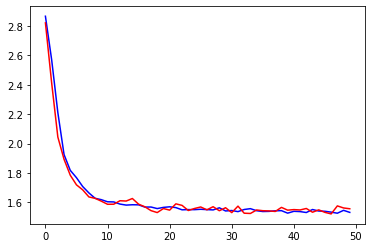

In [12]:
plt.figure()
plt.plot(loss_history['train'],'b-')
plt.plot(loss_history['val'],'r-')

## Test

In [13]:
model.to('cpu')
model.eval()

Resnet20Siamese(
  (distance): PairwiseDistance()
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (co

In [14]:
for i,(img1,img2,label) in enumerate(dataloaders['test']):
    with torch.no_grad():
        out = model(img1,img2)
        loss = criterion(out,label)

    # track total loss
    loss_epoch = loss_epoch+loss
    count = count + len(label)
print('Test loss: {}'.format(loss_epoch.item()/count))
    

Test loss: 1.5669744791666667


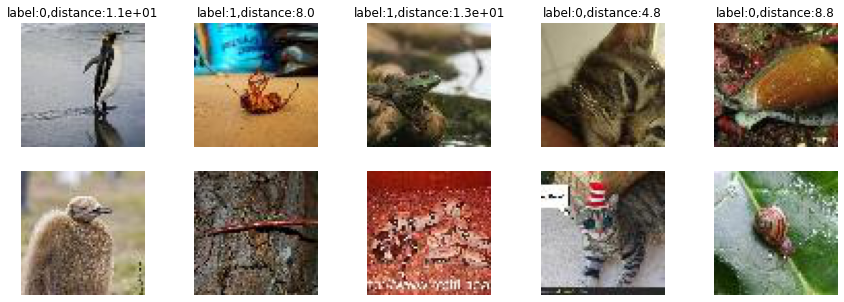

In [18]:
# Visualise
numex=5 #number of examples
fig,ax = plt.subplots(2,numex,figsize=(15,5))
for i in range(numex):
    example = test_dataset[i]
    utils.imshow(example[0],ax[0][i])
    utils.imshow(example[1],ax[1][i])
    distance = model(example[0].reshape(1,3,64,64),example[1].reshape(1,3,64,64))
    ax[0][i].set_title('label:{},distance:{:.2}'.format(example[2].item(),distance.item()))
plt.show()

In [22]:
threshs = np.linspace(start=0,stop=13,num=10)
#threshs = [0.5]
accs = []
sensitivity = []
specificity = []
f1=[]


for thresh in threshs:
    pos=0
    neg=0
    conf = np.zeros((2,2))
    for i,(img1,img2,label) in enumerate(dataloaders['test']):
        with torch.no_grad():
            out = model(img1,img2)
        
        conf[1,1] += torch.sum(label*(out>=thresh))
        conf[1,0] += torch.sum(label*(out<thresh))
        conf[0,1] += torch.sum((1-label)*(out>=thresh))
        conf[0,0] += torch.sum((1-label)*(out<thresh))
        pos = pos + torch.sum(label)
        neg = neg + torch.sum(1-label)

    accs.append(((conf[1,1]+conf[0,0])/(pos+neg)).item())
    sensitivity.append((conf[0,0]/neg).item()) #changed 0 and 1 labels (0 is true in the loss fcn)
    specificity.append((conf[1,1]/pos).item())
    f1.append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])).item())

In [23]:
accs = np.array(accs)
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)
f1 = np.array(f1)

m1 = np.argmax(accs)
m2 = np.argmax(f1)

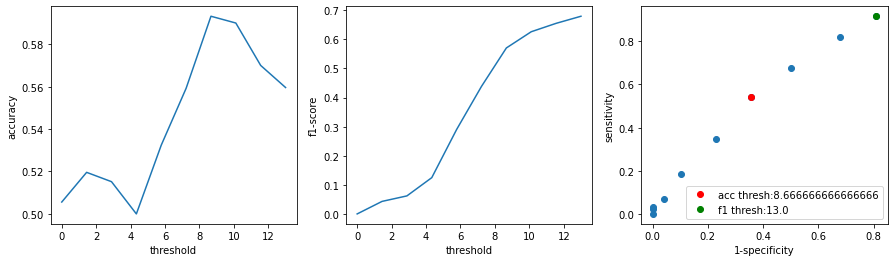

In [24]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(threshs,accs)
ax[0].set_xlabel('threshold')
ax[0].set_ylabel('accuracy')
ax[1].plot(threshs,f1)
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('f1-score')
ax[2].plot(1-specificity,sensitivity,'o',label='_nolabel_')
ax[2].set_xlabel('1-specificity')
ax[2].set_ylabel('sensitivity')
ax[2].plot(1-specificity[m1],sensitivity[m1],'ro',label='acc thresh:{}'.format(threshs[m1]))
ax[2].plot(1-specificity[m2],sensitivity[m2],'go',label='f1 thresh:{}'.format(threshs[m2]))
ax[2].legend()

## Save model

In [20]:
config['MODEL']['modelpath']="models\\resnet_state_dict_50cls.pkl"

In [21]:
torch.save(model.state_dict(),config['MODEL']['modelpath'])